In [1]:
import os
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import warnings
import numpy as np
from sklearn.metrics import mean_squared_error as mse, mean_absolute_error as mae
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
class NYCSTDNDataset():
    def __init__(self,data_path,window_size=7) -> None:
        self.window_size = window_size
        self.data = torch.from_numpy(self.loading(data_path)).float()

    def loading(self,data_path):
        data = np.load(data_path)['volume']
        # print(data.shape)
        self.max_val,self.min_val = np.max(data),np.min(data)
        dataset = slidingWindow(data,self.window_size)
        dataset = np.array(dataset).transpose(0,1,4,2,3) # (1914, 7, 2, 10, 20)
        dataset = dataset.reshape(dataset.shape[0],dataset.shape[1],-1)
        dataset = (dataset - self.min_val) / (self.max_val - self.min_val)
        return dataset
     
    def denormalize(self,x):        
        return x * (self.max_val - self.min_val) + self.min_val

def slidingWindow(seqs,size):
    """
    seqs: ndarray sequence, shape(seqlen,area_nums,2)
    size: sliding window size
    """
    result = []
    for i in range(seqs.shape[0] - size + 1):
        result.append(seqs[i:i + size,:,:,:]) #(7, 10, 20, 2) 
    # print(np.array(result).shape)
    return result

In [4]:
def drawPlot(heights,fname,ylabel):
    """
    功能：绘制训练集上的准确率和测试集上的loss和acc变化曲线
    heights: 纵轴值列表
    fname：保存的文件名
    """
    plt.figure(figsize=(9, 6))
    x = [i for i in range(1,len(heights[0]) + 1)]
    # 绘制训练集和测试集上的loss变化曲线子图
    plt.xlabel("epoch")
    # 设置横坐标的刻度间隔
    plt.xticks([i for i in range(0,len(heights[0]) + 1,5)])
    
    axe1 = plt.subplot(2,2,1)
    plt.ylabel(ylabel[0])
    axe1.plot(x,heights[0],label="train")
    axe1.plot(x,heights[1],label="test")
    axe1.legend()

    axe2 = plt.subplot(2,2,2)
    plt.ylabel(ylabel[1])
    axe2.plot(x,heights[2],label="train")
    axe2.plot(x,heights[3],label="test")
    plt.legend()

    axe3 = plt.subplot(2,2,3)
    plt.ylabel(ylabel[2])
    axe3.plot(x,heights[4],label="train")
    axe3.plot(x,heights[5],label="test")
    plt.legend()

    axe4 = plt.subplot(2,2,4)
    plt.ylabel(ylabel[3])
    axe4.plot(x,heights[6],label="train")
    axe4.plot(x,heights[7],label="test")
    plt.legend()

    plt.savefig("images/{}".format(fname))
    plt.show()

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_index = (y_true > 0)
    y_true = y_true[non_zero_index]
    y_pred = y_pred[non_zero_index]

    mape = np.abs((y_true - y_pred) / y_true)
    mape[np.isinf(mape)] = 0
    return np.mean(mape) * 100

def nextBatch(data,batch_size):
    """
    Divide data into mini-batch
    """
    data_length = len(data)
    num_batches = math.ceil(data_length / batch_size)
    for idx in range(num_batches):
        start_idx = batch_size * idx
        end_idx = min(start_idx + batch_size, data_length)
        yield data[start_idx:end_idx]

In [5]:
class MyLSTM(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,drop_prob):
        super(MyLSTM,self).__init__()
        self.lstm = nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=2)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        """
        x: (batch,seq,feature)
        """
        x,_ = self.lstm(x)
        x = self.dropout(x)
        x = self.fc(torch.mean(x,dim=1))
        x = F.sigmoid(x)
        return x

In [6]:
class MyGRU(nn.Module):
    def __init__(self,input_size,hidden_size,output_size,drop_prob):
        super(MyGRU,self).__init__()
        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=2)
        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(hidden_size,output_size)

    def forward(self,x):
        """
        x: (batch,seq,feature)
        """
        x,_ = self.gru(x)
        x = self.dropout(x)
        x = self.fc(torch.mean(x,dim=1))
        x = F.sigmoid(x)
        return x

In [7]:
class CNNLSTM(nn.Module):
    def __init__(self,in_channel,out_channels,input_size,hidden_size,output_size,drop_prob):
        super(CNNLSTM,self).__init__()

        self.convs = nn.Sequential(
            nn.Conv3d(in_channels=in_channel, out_channels=out_channels[0], kernel_size=(3, 3, 3)),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=(3, 3, 3)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        self.lstm = nn.LSTM(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=2)

        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(384 + hidden_size,output_size)

    def forward(self,x):
        """
        x: (batch,depth/seqlen,channels*h*w)
        """
        x = x.view(x.shape[0],x.shape[1],2,10,20)
        cnn_feats = self.convs(x.transpose(1,2))
        # print(cnn_feats.shape)
        gru_out,_ = self.lstm(x.view(x.shape[0],x.shape[1],-1))
        gru_feats =torch.mean(gru_out,dim=1)
        fusion_feats = torch.cat((cnn_feats.view(cnn_feats.shape[0],-1),gru_feats),dim=1)
        x = self.fc(self.dropout(fusion_feats))
        return F.sigmoid(x)

In [8]:
class CNNGRU(nn.Module):
    def __init__(self,in_channel,out_channels,input_size,hidden_size,output_size,drop_prob):
        super(CNNGRU,self).__init__()

        self.convs = nn.Sequential(
            nn.Conv3d(in_channels=in_channel, out_channels=out_channels[0], kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2)),
            nn.Conv3d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.Conv3d(in_channels=out_channels[0], out_channels=out_channels[1], kernel_size=(3, 3, 3), padding=(1, 1, 1)),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        )

        self.gru = nn.GRU(input_size=input_size,
                          hidden_size=hidden_size,
                          batch_first=True,
                          num_layers=2)

        self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Linear(4 + hidden_size,output_size)

    def forward(self,x):
        """
        x: (batch,depth/seqlen,channels*h*w)
        """
        x = x.view(x.shape[0],x.shape[1],2,10,20)
        cnn_feats = self.convs(x.transpose(1,2))
        gru_out,_ = self.gru(x.view(x.shape[0],x.shape[1],-1))
        gru_feats =torch.mean(gru_out,dim=1)
        fusion_feats = torch.cat((cnn_feats.view(cnn_feats.shape[0],-1),gru_feats),dim=1)
        x = self.fc(self.dropout(fusion_feats))
        return F.sigmoid(x)

In [9]:
def train_one_epoch(model,train_dataset,loss_fn,optimizer):
    model.train()
    iteration = 0
    for batch in nextBatch(shuffle(train_dataset.data),batch_size):
        x,y = batch[:,:-1,:], batch[:,-1,:]
        x,y = x.to(device),y.to(device)
        y_hat = model(x)
        l = loss_fn(y_hat, y)
        optimizer.zero_grad(set_to_none=True)
        l.backward()
        # # 梯度裁剪
        # nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0, norm_type=2)
        optimizer.step()
        iteration += 1
        if iteration % 10 == 0:
            print("Iteraion {}, Train Loss: {:.8f}".format(iteration, l.item()))
    
    train_rmse,train_mae,train_mape,train_loss = test(model,train_dataset,loss_fn)
    
    return (train_rmse,train_mae,train_mape,train_loss)

In [10]:
def test(model,test_dataset,loss_fn):
    model.eval()
    y_hats = []
    test_l_sum,c = 0,0
    with torch.no_grad():
        for batch in nextBatch(test_dataset.data, batch_size=batch_size):
            x,y = batch[:,:-1,:], batch[:,-1,:]
            x,y = x.to(device),y.to(device)
            y_hat = model(x)
            test_l_sum += loss_fn(y_hat,y).item()
            c += 1
            y_hats.append(y_hat.detach().cpu().numpy())
        y_hats = np.concatenate(y_hats)
    y_true = test_dataset.data[:,-1,:]
    y_hats = test_dataset.denormalize(y_hats)
    y_true = test_dataset.denormalize(y_true)
    y_true = y_true.reshape(y_true.size(0),-1)
    rmse_score,mae_score,mape_score = math.sqrt(mse(y_true, y_hats)), \
                                mae(y_true, y_hats), \
                                mape(y_true, y_hats)    
    return (rmse_score,mae_score,mape_score,test_l_sum / c)

In [11]:
train_dataset,test_dataset = NYCSTDNDataset(data_path='NYC-stdn/volume_train.npz'),\
                                NYCSTDNDataset(data_path='NYC-stdn/volume_test.npz')
print("loading dataset done")

loading dataset done


In [12]:
# model_type = "lstm"
# model_type = "gru"
model_type = "cnnlstm"
# model_type = "cnngru"
batch_size = 64
epochs = 1000
lr = 0.001
lr_drop = [500,750]
drop_prob = 0.3
hidden_size = 64

In [21]:
if model_type == "gru":
    model = MyGRU(input_size=400,
                  hidden_size=hidden_size,
                  output_size=400,
                  drop_prob=drop_prob)
elif model_type == "lstm":
    model = MyLSTM(input_size=400,
                   hidden_size=hidden_size,
                   output_size=400,
                   drop_prob=drop_prob)
elif model_type == "cnngru":
    model = CNNGRU(
                   in_channel=2,
                   out_channels=[2,2],
                   input_size=400,
                   hidden_size=hidden_size,
                   output_size=400,
                   drop_prob=drop_prob)
elif model_type == "cnnlstm":
    model = CNNLSTM(
                   in_channel=2,
                   out_channels=[64,128],
                   input_size=400,
                   hidden_size=hidden_size,
                   output_size=400,
                   drop_prob=drop_prob)
print("loading model {} done".format(model_type))

loading model cnnlstm done


In [22]:
model.to(device)
optimizer =  optim.Adam(params=model.parameters(),lr=lr)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, lr_drop)
loss_fn = nn.MSELoss()

In [23]:
train_loss_list,test_loss_list = [],[]
train_rmse_list,train_mae_list,train_mape_list = [],[],[]
test_rmse_list,test_mae_list,test_mape_list = [],[],[]
train_times = 0.0
best_epoch, best_rmse, best_mae, best_mape, best_train_loss, best_test_loss = 0, float("inf"), float("inf"), float("inf"), float("inf"), float("inf")
for i in range(epochs):
    print("=========epoch {}=========".format(i + 1))
    train_rmse,train_mae,train_mape,train_loss = train_one_epoch(model,train_dataset,loss_fn,optimizer)
    train_loss_list.append(train_loss)
    train_rmse_list.append(train_rmse)
    train_mae_list.append(train_mae)
    train_mape_list.append(train_mape)
    lr_scheduler.step()
    print('Epoch: {}, RMSE: {:.4f}, MAE: {:.4f}, MAPE: {:.4f},Train Loss: {:.8f}'.format(
        i + 1,train_rmse,train_mae,train_mape,train_loss))
    # eval
    test_rmse,test_mae,test_mape,test_loss = test(model,test_dataset,loss_fn)
    test_loss_list.append(test_loss)
    test_rmse_list.append(test_rmse)
    test_mae_list.append(test_mae)
    test_mape_list.append(test_mape)
    if test_rmse<best_rmse:
        best_epoch = i
        best_rmse = test_rmse
        best_mae = test_mae
        best_mape = test_mape
        best_train_loss = train_loss
        best_test_loss = test_loss
    print('Epoch: {}, RMSE: {:.4f}, MAE: {:.4f}, MAPE: {:.4f},Test Loss: {:.8f}'.format(
        i + 1,test_rmse,test_mae,test_mape,test_loss))

=========epoch 1=========
Iteraion 10, Train Loss: 0.00722381
Iteraion 20, Train Loss: 0.00511106
Iteraion 30, Train Loss: 0.00471900
Epoch: 1, RMSE: 84.8969, MAE: 31.3672, MAPE: 108.0310,Train Loss: 0.00437562
Epoch: 1, RMSE: 89.6985, MAE: 34.0741, MAPE: 101.0627,Test Loss: 0.00484085
=========epoch 2=========
Iteraion 10, Train Loss: 0.00462153
Iteraion 20, Train Loss: 0.00441196
Iteraion 30, Train Loss: 0.00495958
Epoch: 2, RMSE: 75.3380, MAE: 27.8388, MAPE: 101.8228,Train Loss: 0.00344556
Epoch: 2, RMSE: 79.4415, MAE: 30.1970, MAPE: 97.6448,Test Loss: 0.00379866
=========epoch 3=========
Iteraion 10, Train Loss: 0.00443056
Iteraion 20, Train Loss: 0.00382092
Iteraion 30, Train Loss: 0.00367955
Epoch: 3, RMSE: 73.6077, MAE: 27.1279, MAPE: 99.9948,Train Loss: 0.00328920
Epoch: 3, RMSE: 77.7248, MAE: 29.5133, MAPE: 96.2822,Test Loss: 0.00363617
=========epoch 4=========
Iteraion 10, Train Loss: 0.00402534
Iteraion 20, Train Loss: 0.00310742
Iteraion 30, Train Loss: 0.00349074
Epoch: 4

Iteraion 10, Train Loss: 0.00021450
Iteraion 20, Train Loss: 0.00030373
Iteraion 30, Train Loss: 0.00021230
Epoch: 30, RMSE: 17.4561, MAE: 7.5751, MAPE: 81.0010,Train Loss: 0.00018499
Epoch: 30, RMSE: 18.9425, MAE: 8.1983, MAPE: 73.2547,Test Loss: 0.00021571
=========epoch 31=========
Iteraion 10, Train Loss: 0.00021055
Iteraion 20, Train Loss: 0.00025192
Iteraion 30, Train Loss: 0.00023320
Epoch: 31, RMSE: 17.1527, MAE: 7.4725, MAPE: 81.4613,Train Loss: 0.00017860
Epoch: 31, RMSE: 18.4673, MAE: 8.0267, MAPE: 74.0546,Test Loss: 0.00020507
=========epoch 32=========
Iteraion 10, Train Loss: 0.00024465
Iteraion 20, Train Loss: 0.00024772
Iteraion 30, Train Loss: 0.00024626
Epoch: 32, RMSE: 17.3690, MAE: 7.3931, MAPE: 77.7912,Train Loss: 0.00018313
Epoch: 32, RMSE: 18.8351, MAE: 8.0005, MAPE: 70.5220,Test Loss: 0.00021328
=========epoch 33=========
Iteraion 10, Train Loss: 0.00028058
Iteraion 20, Train Loss: 0.00021222
Iteraion 30, Train Loss: 0.00021947
Epoch: 33, RMSE: 17.1018, MAE: 7.3

Iteraion 10, Train Loss: 0.00016840
Iteraion 20, Train Loss: 0.00016159
Iteraion 30, Train Loss: 0.00016094
Epoch: 59, RMSE: 15.2086, MAE: 6.0651, MAPE: 53.2908,Train Loss: 0.00014043
Epoch: 59, RMSE: 16.9094, MAE: 6.7366, MAPE: 48.8441,Test Loss: 0.00017193
=========epoch 60=========
Iteraion 10, Train Loss: 0.00019271
Iteraion 20, Train Loss: 0.00016942
Iteraion 30, Train Loss: 0.00017403
Epoch: 60, RMSE: 14.6801, MAE: 5.9626, MAPE: 54.2663,Train Loss: 0.00013083
Epoch: 60, RMSE: 16.1154, MAE: 6.5515, MAPE: 49.7937,Test Loss: 0.00015621
=========epoch 61=========
Iteraion 10, Train Loss: 0.00018254
Iteraion 20, Train Loss: 0.00015375
Iteraion 30, Train Loss: 0.00016058
Epoch: 61, RMSE: 14.8338, MAE: 5.9393, MAPE: 52.4137,Train Loss: 0.00013359
Epoch: 61, RMSE: 16.5570, MAE: 6.6096, MAPE: 47.9174,Test Loss: 0.00016485
=========epoch 62=========
Iteraion 10, Train Loss: 0.00017862
Iteraion 20, Train Loss: 0.00015578
Iteraion 30, Train Loss: 0.00015469
Epoch: 62, RMSE: 14.5506, MAE: 5.9

Iteraion 10, Train Loss: 0.00015149
Iteraion 20, Train Loss: 0.00013540
Iteraion 30, Train Loss: 0.00014653
Epoch: 88, RMSE: 13.8340, MAE: 5.4762, MAPE: 46.2788,Train Loss: 0.00011618
Epoch: 88, RMSE: 15.5523, MAE: 6.1518, MAPE: 42.5406,Test Loss: 0.00014546
=========epoch 89=========
Iteraion 10, Train Loss: 0.00016183
Iteraion 20, Train Loss: 0.00017166
Iteraion 30, Train Loss: 0.00015017
Epoch: 89, RMSE: 13.4407, MAE: 5.5102, MAPE: 50.3946,Train Loss: 0.00010967
Epoch: 89, RMSE: 15.0947, MAE: 6.0989, MAPE: 46.8804,Test Loss: 0.00013708
=========epoch 90=========
Iteraion 10, Train Loss: 0.00013455
Iteraion 20, Train Loss: 0.00013761
Iteraion 30, Train Loss: 0.00013687
Epoch: 90, RMSE: 14.5640, MAE: 5.5974, MAPE: 44.4937,Train Loss: 0.00012877
Epoch: 90, RMSE: 16.4438, MAE: 6.3432, MAPE: 41.3676,Test Loss: 0.00016257
=========epoch 91=========
Iteraion 10, Train Loss: 0.00015411
Iteraion 20, Train Loss: 0.00013304
Iteraion 30, Train Loss: 0.00016927
Epoch: 91, RMSE: 13.5965, MAE: 5.5

Iteraion 10, Train Loss: 0.00011515
Iteraion 20, Train Loss: 0.00013518
Iteraion 30, Train Loss: 0.00012115
Epoch: 117, RMSE: 12.5995, MAE: 5.1101, MAPE: 46.4151,Train Loss: 0.00009639
Epoch: 117, RMSE: 14.4989, MAE: 5.7225, MAPE: 43.1103,Test Loss: 0.00012652
=========epoch 118=========
Iteraion 10, Train Loss: 0.00013888
Iteraion 20, Train Loss: 0.00011494
Iteraion 30, Train Loss: 0.00013293
Epoch: 118, RMSE: 12.4743, MAE: 4.9204, MAPE: 41.8008,Train Loss: 0.00009447
Epoch: 118, RMSE: 14.4045, MAE: 5.6195, MAPE: 39.3290,Test Loss: 0.00012482
=========epoch 119=========
Iteraion 10, Train Loss: 0.00013789
Iteraion 20, Train Loss: 0.00012650
Iteraion 30, Train Loss: 0.00013169
Epoch: 119, RMSE: 12.3456, MAE: 4.9474, MAPE: 43.5532,Train Loss: 0.00009253
Epoch: 119, RMSE: 14.2106, MAE: 5.6191, MAPE: 40.4990,Test Loss: 0.00012150
=========epoch 120=========
Iteraion 10, Train Loss: 0.00011588
Iteraion 20, Train Loss: 0.00014651
Iteraion 30, Train Loss: 0.00012693
Epoch: 120, RMSE: 12.6733

Epoch: 145, RMSE: 12.0672, MAE: 4.7968, MAPE: 40.0066,Train Loss: 0.00008842
Epoch: 145, RMSE: 14.2311, MAE: 5.5846, MAPE: 37.7844,Test Loss: 0.00012181
=========epoch 146=========
Iteraion 10, Train Loss: 0.00012444
Iteraion 20, Train Loss: 0.00012499
Iteraion 30, Train Loss: 0.00010290
Epoch: 146, RMSE: 11.8238, MAE: 4.6866, MAPE: 41.2194,Train Loss: 0.00008490
Epoch: 146, RMSE: 13.9178, MAE: 5.4230, MAPE: 38.7626,Test Loss: 0.00011650
=========epoch 147=========
Iteraion 10, Train Loss: 0.00009938
Iteraion 20, Train Loss: 0.00012515
Iteraion 30, Train Loss: 0.00011409
Epoch: 147, RMSE: 11.6401, MAE: 4.6353, MAPE: 41.0124,Train Loss: 0.00008227
Epoch: 147, RMSE: 13.6072, MAE: 5.3240, MAPE: 38.4545,Test Loss: 0.00011140
=========epoch 148=========
Iteraion 10, Train Loss: 0.00011062
Iteraion 20, Train Loss: 0.00010962
Iteraion 30, Train Loss: 0.00010463
Epoch: 148, RMSE: 12.2095, MAE: 4.8161, MAPE: 40.9381,Train Loss: 0.00009050
Epoch: 148, RMSE: 14.2826, MAE: 5.5533, MAPE: 38.1576,Te

Iteraion 10, Train Loss: 0.00011415
Iteraion 20, Train Loss: 0.00010634
Iteraion 30, Train Loss: 0.00010233
Epoch: 174, RMSE: 11.6197, MAE: 4.5541, MAPE: 37.9796,Train Loss: 0.00008200
Epoch: 174, RMSE: 13.8047, MAE: 5.3218, MAPE: 35.8439,Test Loss: 0.00011461
=========epoch 175=========
Iteraion 10, Train Loss: 0.00010276
Iteraion 20, Train Loss: 0.00012055
Iteraion 30, Train Loss: 0.00010735
Epoch: 175, RMSE: 11.2835, MAE: 4.4626, MAPE: 37.4247,Train Loss: 0.00007731
Epoch: 175, RMSE: 13.4494, MAE: 5.2228, MAPE: 35.4180,Test Loss: 0.00010886
=========epoch 176=========
Iteraion 10, Train Loss: 0.00012969
Iteraion 20, Train Loss: 0.00009414
Iteraion 30, Train Loss: 0.00008637
Epoch: 176, RMSE: 11.2519, MAE: 4.4850, MAPE: 39.3789,Train Loss: 0.00007687
Epoch: 176, RMSE: 13.3462, MAE: 5.1817, MAPE: 36.9644,Test Loss: 0.00010722
=========epoch 177=========
Iteraion 10, Train Loss: 0.00009841
Iteraion 20, Train Loss: 0.00010878
Iteraion 30, Train Loss: 0.00010792
Epoch: 177, RMSE: 11.7793

Epoch: 202, RMSE: 11.0516, MAE: 4.4513, MAPE: 40.5344,Train Loss: 0.00007416
Epoch: 202, RMSE: 13.1938, MAE: 5.1218, MAPE: 37.4155,Test Loss: 0.00010475
=========epoch 203=========
Iteraion 10, Train Loss: 0.00010080
Iteraion 20, Train Loss: 0.00011212
Iteraion 30, Train Loss: 0.00012041
Epoch: 203, RMSE: 11.5533, MAE: 4.6341, MAPE: 39.5664,Train Loss: 0.00008104
Epoch: 203, RMSE: 13.7331, MAE: 5.3300, MAPE: 37.0182,Test Loss: 0.00011355
=========epoch 204=========
Iteraion 10, Train Loss: 0.00011081
Iteraion 20, Train Loss: 0.00010627
Iteraion 30, Train Loss: 0.00010820
Epoch: 204, RMSE: 11.3860, MAE: 4.4576, MAPE: 38.1267,Train Loss: 0.00007871
Epoch: 204, RMSE: 13.6614, MAE: 5.1957, MAPE: 35.9121,Test Loss: 0.00011235
=========epoch 205=========
Iteraion 10, Train Loss: 0.00010286
Iteraion 20, Train Loss: 0.00009099
Iteraion 30, Train Loss: 0.00009727
Epoch: 205, RMSE: 10.8476, MAE: 4.2921, MAPE: 36.6260,Train Loss: 0.00007145
Epoch: 205, RMSE: 13.2075, MAE: 5.0861, MAPE: 34.6238,Te

Iteraion 10, Train Loss: 0.00010377
Iteraion 20, Train Loss: 0.00009667
Iteraion 30, Train Loss: 0.00010823
Epoch: 231, RMSE: 11.0422, MAE: 4.2895, MAPE: 34.6820,Train Loss: 0.00007404
Epoch: 231, RMSE: 13.4890, MAE: 5.1348, MAPE: 33.2132,Test Loss: 0.00010946
=========epoch 232=========
Iteraion 10, Train Loss: 0.00009756
Iteraion 20, Train Loss: 0.00011831
Iteraion 30, Train Loss: 0.00009652
Epoch: 232, RMSE: 10.8625, MAE: 4.2618, MAPE: 34.5803,Train Loss: 0.00007165
Epoch: 232, RMSE: 13.2008, MAE: 5.0857, MAPE: 33.0509,Test Loss: 0.00010486
=========epoch 233=========
Iteraion 10, Train Loss: 0.00008704
Iteraion 20, Train Loss: 0.00009992
Iteraion 30, Train Loss: 0.00008960
Epoch: 233, RMSE: 10.6319, MAE: 4.1818, MAPE: 35.2755,Train Loss: 0.00006864
Epoch: 233, RMSE: 13.0810, MAE: 4.9890, MAPE: 33.6086,Test Loss: 0.00010296
=========epoch 234=========
Iteraion 10, Train Loss: 0.00008363
Iteraion 20, Train Loss: 0.00009639
Iteraion 30, Train Loss: 0.00009604
Epoch: 234, RMSE: 10.4537

Epoch: 259, RMSE: 10.6844, MAE: 4.1356, MAPE: 33.9688,Train Loss: 0.00006932
Epoch: 259, RMSE: 13.2791, MAE: 4.9949, MAPE: 32.8070,Test Loss: 0.00010609
=========epoch 260=========
Iteraion 10, Train Loss: 0.00010137
Iteraion 20, Train Loss: 0.00009663
Iteraion 30, Train Loss: 0.00009266
Epoch: 260, RMSE: 10.3359, MAE: 4.0780, MAPE: 36.2337,Train Loss: 0.00006488
Epoch: 260, RMSE: 12.9809, MAE: 4.9105, MAPE: 34.2945,Test Loss: 0.00010138
=========epoch 261=========
Iteraion 10, Train Loss: 0.00007869
Iteraion 20, Train Loss: 0.00009605
Iteraion 30, Train Loss: 0.00008261
Epoch: 261, RMSE: 10.2419, MAE: 4.0274, MAPE: 34.2463,Train Loss: 0.00006370
Epoch: 261, RMSE: 12.8120, MAE: 4.8676, MAPE: 32.8806,Test Loss: 0.00009879
=========epoch 262=========
Iteraion 10, Train Loss: 0.00008305
Iteraion 20, Train Loss: 0.00007321
Iteraion 30, Train Loss: 0.00008093
Epoch: 262, RMSE: 10.2499, MAE: 4.0295, MAPE: 34.5738,Train Loss: 0.00006380
Epoch: 262, RMSE: 13.0764, MAE: 4.9372, MAPE: 33.1057,Te

Iteraion 10, Train Loss: 0.00008970
Iteraion 20, Train Loss: 0.00007830
Iteraion 30, Train Loss: 0.00008240
Epoch: 288, RMSE: 9.9436, MAE: 3.9340, MAPE: 35.0018,Train Loss: 0.00006005
Epoch: 288, RMSE: 12.7128, MAE: 4.7842, MAPE: 33.5104,Test Loss: 0.00009728
=========epoch 289=========
Iteraion 10, Train Loss: 0.00008355
Iteraion 20, Train Loss: 0.00007538
Iteraion 30, Train Loss: 0.00009559
Epoch: 289, RMSE: 9.8660, MAE: 3.9121, MAPE: 35.0386,Train Loss: 0.00005911
Epoch: 289, RMSE: 12.5661, MAE: 4.7608, MAPE: 33.4986,Test Loss: 0.00009502
=========epoch 290=========
Iteraion 10, Train Loss: 0.00010877
Iteraion 20, Train Loss: 0.00009094
Iteraion 30, Train Loss: 0.00008168
Epoch: 290, RMSE: 9.8199, MAE: 3.8776, MAPE: 34.2470,Train Loss: 0.00005856
Epoch: 290, RMSE: 12.6660, MAE: 4.7700, MAPE: 32.8945,Test Loss: 0.00009653
=========epoch 291=========
Iteraion 10, Train Loss: 0.00007535
Iteraion 20, Train Loss: 0.00010871
Iteraion 30, Train Loss: 0.00008737
Epoch: 291, RMSE: 9.9822, MA

Iteraion 10, Train Loss: 0.00009362
Iteraion 20, Train Loss: 0.00007678
Iteraion 30, Train Loss: 0.00006695
Epoch: 317, RMSE: 9.8997, MAE: 3.8829, MAPE: 33.9631,Train Loss: 0.00005952
Epoch: 317, RMSE: 12.9169, MAE: 4.8381, MAPE: 32.8473,Test Loss: 0.00010040
=========epoch 318=========
Iteraion 10, Train Loss: 0.00008666
Iteraion 20, Train Loss: 0.00009908
Iteraion 30, Train Loss: 0.00007784
Epoch: 318, RMSE: 9.5753, MAE: 3.8199, MAPE: 34.4991,Train Loss: 0.00005568
Epoch: 318, RMSE: 12.5858, MAE: 4.7545, MAPE: 33.3809,Test Loss: 0.00009531
=========epoch 319=========
Iteraion 10, Train Loss: 0.00008273
Iteraion 20, Train Loss: 0.00008698
Iteraion 30, Train Loss: 0.00007251
Epoch: 319, RMSE: 9.7125, MAE: 3.8280, MAPE: 33.3886,Train Loss: 0.00005729
Epoch: 319, RMSE: 12.7004, MAE: 4.7705, MAPE: 32.3974,Test Loss: 0.00009708
=========epoch 320=========
Iteraion 10, Train Loss: 0.00008727
Iteraion 20, Train Loss: 0.00007575
Iteraion 30, Train Loss: 0.00009303
Epoch: 320, RMSE: 9.4824, MA

Iteraion 10, Train Loss: 0.00007554
Iteraion 20, Train Loss: 0.00008669
Iteraion 30, Train Loss: 0.00008770
Epoch: 346, RMSE: 9.5005, MAE: 3.7840, MAPE: 32.4669,Train Loss: 0.00005482
Epoch: 346, RMSE: 12.7888, MAE: 4.8151, MAPE: 32.1182,Test Loss: 0.00009839
=========epoch 347=========
Iteraion 10, Train Loss: 0.00008476
Iteraion 20, Train Loss: 0.00008016
Iteraion 30, Train Loss: 0.00008043
Epoch: 347, RMSE: 9.6780, MAE: 3.8668, MAPE: 34.5976,Train Loss: 0.00005688
Epoch: 347, RMSE: 12.8226, MAE: 4.7905, MAPE: 33.3942,Test Loss: 0.00009900
=========epoch 348=========
Iteraion 10, Train Loss: 0.00007724
Iteraion 20, Train Loss: 0.00008418
Iteraion 30, Train Loss: 0.00008544
Epoch: 348, RMSE: 9.3898, MAE: 3.7341, MAPE: 34.0929,Train Loss: 0.00005355
Epoch: 348, RMSE: 12.6697, MAE: 4.7132, MAPE: 33.0986,Test Loss: 0.00009664
=========epoch 349=========
Iteraion 10, Train Loss: 0.00008564
Iteraion 20, Train Loss: 0.00007342
Iteraion 30, Train Loss: 0.00006535
Epoch: 349, RMSE: 9.2133, MA

Iteraion 10, Train Loss: 0.00007363
Iteraion 20, Train Loss: 0.00008283
Iteraion 30, Train Loss: 0.00007802
Epoch: 375, RMSE: 9.0887, MAE: 3.6503, MAPE: 34.0605,Train Loss: 0.00005017
Epoch: 375, RMSE: 12.6684, MAE: 4.7055, MAPE: 33.3657,Test Loss: 0.00009661
=========epoch 376=========
Iteraion 10, Train Loss: 0.00007777
Iteraion 20, Train Loss: 0.00007822
Iteraion 30, Train Loss: 0.00007247
Epoch: 376, RMSE: 9.6760, MAE: 3.8823, MAPE: 35.2180,Train Loss: 0.00005686
Epoch: 376, RMSE: 13.0286, MAE: 4.8548, MAPE: 34.0092,Test Loss: 0.00010221
=========epoch 377=========
Iteraion 10, Train Loss: 0.00007006
Iteraion 20, Train Loss: 0.00007590
Iteraion 30, Train Loss: 0.00007040
Epoch: 377, RMSE: 9.5708, MAE: 3.7650, MAPE: 32.7421,Train Loss: 0.00005563
Epoch: 377, RMSE: 12.9921, MAE: 4.8283, MAPE: 32.4330,Test Loss: 0.00010158
=========epoch 378=========
Iteraion 10, Train Loss: 0.00007676
Iteraion 20, Train Loss: 0.00008483
Iteraion 30, Train Loss: 0.00007464
Epoch: 378, RMSE: 9.2173, MA

Iteraion 10, Train Loss: 0.00006494
Iteraion 20, Train Loss: 0.00007320
Iteraion 30, Train Loss: 0.00007245
Epoch: 404, RMSE: 8.9847, MAE: 3.5600, MAPE: 32.4015,Train Loss: 0.00004903
Epoch: 404, RMSE: 12.5761, MAE: 4.6550, MAPE: 32.3048,Test Loss: 0.00009518
=========epoch 405=========
Iteraion 10, Train Loss: 0.00007193
Iteraion 20, Train Loss: 0.00006967
Iteraion 30, Train Loss: 0.00007320
Epoch: 405, RMSE: 8.8766, MAE: 3.5649, MAPE: 33.6466,Train Loss: 0.00004786
Epoch: 405, RMSE: 12.4503, MAE: 4.6224, MAPE: 33.2057,Test Loss: 0.00009331
=========epoch 406=========
Iteraion 10, Train Loss: 0.00007347
Iteraion 20, Train Loss: 0.00007157
Iteraion 30, Train Loss: 0.00007488
Epoch: 406, RMSE: 8.7768, MAE: 3.5600, MAPE: 34.4984,Train Loss: 0.00004679
Epoch: 406, RMSE: 12.4517, MAE: 4.6173, MAPE: 33.8130,Test Loss: 0.00009336
=========epoch 407=========
Iteraion 10, Train Loss: 0.00008268
Iteraion 20, Train Loss: 0.00006290
Iteraion 30, Train Loss: 0.00007313
Epoch: 407, RMSE: 8.9765, MA

Iteraion 10, Train Loss: 0.00007072
Iteraion 20, Train Loss: 0.00006963
Iteraion 30, Train Loss: 0.00006610
Epoch: 433, RMSE: 10.1307, MAE: 3.9198, MAPE: 32.5073,Train Loss: 0.00006232
Epoch: 433, RMSE: 13.7935, MAE: 5.0448, MAPE: 32.6117,Test Loss: 0.00011444
=========epoch 434=========
Iteraion 10, Train Loss: 0.00007095
Iteraion 20, Train Loss: 0.00007235
Iteraion 30, Train Loss: 0.00007590
Epoch: 434, RMSE: 9.0095, MAE: 3.5892, MAPE: 32.7378,Train Loss: 0.00004930
Epoch: 434, RMSE: 12.8739, MAE: 4.7321, MAPE: 32.8168,Test Loss: 0.00009972
=========epoch 435=========
Iteraion 10, Train Loss: 0.00007204
Iteraion 20, Train Loss: 0.00006726
Iteraion 30, Train Loss: 0.00007391
Epoch: 435, RMSE: 8.6221, MAE: 3.4776, MAPE: 32.4851,Train Loss: 0.00004515
Epoch: 435, RMSE: 12.5847, MAE: 4.6566, MAPE: 32.5576,Test Loss: 0.00009536
=========epoch 436=========
Iteraion 10, Train Loss: 0.00006721
Iteraion 20, Train Loss: 0.00007166
Iteraion 30, Train Loss: 0.00006223
Epoch: 436, RMSE: 8.5054, M

Iteraion 10, Train Loss: 0.00006055
Iteraion 20, Train Loss: 0.00007632
Iteraion 30, Train Loss: 0.00007583
Epoch: 462, RMSE: 8.5069, MAE: 3.4562, MAPE: 32.0197,Train Loss: 0.00004395
Epoch: 462, RMSE: 12.6044, MAE: 4.6848, MAPE: 32.3312,Test Loss: 0.00009562
=========epoch 463=========
Iteraion 10, Train Loss: 0.00005906
Iteraion 20, Train Loss: 0.00006702
Iteraion 30, Train Loss: 0.00006314
Epoch: 463, RMSE: 8.3761, MAE: 3.4363, MAPE: 33.2223,Train Loss: 0.00004261
Epoch: 463, RMSE: 12.4444, MAE: 4.5992, MAPE: 33.0331,Test Loss: 0.00009323
=========epoch 464=========
Iteraion 10, Train Loss: 0.00006729
Iteraion 20, Train Loss: 0.00006850
Iteraion 30, Train Loss: 0.00006563
Epoch: 464, RMSE: 8.8580, MAE: 3.5605, MAPE: 32.0357,Train Loss: 0.00004767
Epoch: 464, RMSE: 12.8285, MAE: 4.7432, MAPE: 32.3915,Test Loss: 0.00009903
=========epoch 465=========
Iteraion 10, Train Loss: 0.00007346
Iteraion 20, Train Loss: 0.00006249
Iteraion 30, Train Loss: 0.00005947
Epoch: 465, RMSE: 8.1435, MA

Epoch: 490, RMSE: 12.9819, MAE: 4.7848, MAPE: 32.4193,Test Loss: 0.00010152
=========epoch 491=========
Iteraion 10, Train Loss: 0.00006460
Iteraion 20, Train Loss: 0.00006308
Iteraion 30, Train Loss: 0.00007139
Epoch: 491, RMSE: 8.5504, MAE: 3.5605, MAPE: 35.3849,Train Loss: 0.00004440
Epoch: 491, RMSE: 12.6878, MAE: 4.6990, MAPE: 34.6554,Test Loss: 0.00009690
=========epoch 492=========
Iteraion 10, Train Loss: 0.00005804
Iteraion 20, Train Loss: 0.00006056
Iteraion 30, Train Loss: 0.00006526
Epoch: 492, RMSE: 8.2507, MAE: 3.3640, MAPE: 32.5129,Train Loss: 0.00004135
Epoch: 492, RMSE: 12.5934, MAE: 4.6157, MAPE: 32.8389,Test Loss: 0.00009545
=========epoch 493=========
Iteraion 10, Train Loss: 0.00005234
Iteraion 20, Train Loss: 0.00006383
Iteraion 30, Train Loss: 0.00005650
Epoch: 493, RMSE: 8.0753, MAE: 3.3281, MAPE: 33.1327,Train Loss: 0.00003961
Epoch: 493, RMSE: 12.4149, MAE: 4.5702, MAPE: 33.0967,Test Loss: 0.00009279
=========epoch 494=========
Iteraion 10, Train Loss: 0.00006

Iteraion 20, Train Loss: 0.00005484
Iteraion 30, Train Loss: 0.00004683
Epoch: 519, RMSE: 7.5720, MAE: 3.1553, MAPE: 32.1135,Train Loss: 0.00003483
Epoch: 519, RMSE: 12.2382, MAE: 4.4965, MAPE: 32.6223,Test Loss: 0.00009015
=========epoch 520=========
Iteraion 10, Train Loss: 0.00005834
Iteraion 20, Train Loss: 0.00005003
Iteraion 30, Train Loss: 0.00005060
Epoch: 520, RMSE: 7.5664, MAE: 3.1538, MAPE: 32.4671,Train Loss: 0.00003477
Epoch: 520, RMSE: 12.1959, MAE: 4.4746, MAPE: 32.8090,Test Loss: 0.00008954
=========epoch 521=========
Iteraion 10, Train Loss: 0.00005704
Iteraion 20, Train Loss: 0.00005963
Iteraion 30, Train Loss: 0.00005462
Epoch: 521, RMSE: 7.5495, MAE: 3.1526, MAPE: 32.4091,Train Loss: 0.00003462
Epoch: 521, RMSE: 12.2079, MAE: 4.4879, MAPE: 32.8731,Test Loss: 0.00008972
=========epoch 522=========
Iteraion 10, Train Loss: 0.00005415
Iteraion 20, Train Loss: 0.00004751
Iteraion 30, Train Loss: 0.00005407
Epoch: 522, RMSE: 7.5644, MAE: 3.1503, MAPE: 32.2135,Train Loss:

Iteraion 10, Train Loss: 0.00005858
Iteraion 20, Train Loss: 0.00005453
Iteraion 30, Train Loss: 0.00005374
Epoch: 548, RMSE: 7.4852, MAE: 3.1281, MAPE: 32.6942,Train Loss: 0.00003403
Epoch: 548, RMSE: 12.1590, MAE: 4.4605, MAPE: 33.0700,Test Loss: 0.00008899
=========epoch 549=========
Iteraion 10, Train Loss: 0.00006408
Iteraion 20, Train Loss: 0.00004797
Iteraion 30, Train Loss: 0.00005387
Epoch: 549, RMSE: 7.4886, MAE: 3.1267, MAPE: 32.4721,Train Loss: 0.00003406
Epoch: 549, RMSE: 12.1695, MAE: 4.4618, MAPE: 32.8984,Test Loss: 0.00008915
=========epoch 550=========
Iteraion 10, Train Loss: 0.00005488
Iteraion 20, Train Loss: 0.00004559
Iteraion 30, Train Loss: 0.00005849
Epoch: 550, RMSE: 7.5080, MAE: 3.1372, MAPE: 32.2794,Train Loss: 0.00003424
Epoch: 550, RMSE: 12.1946, MAE: 4.4769, MAPE: 32.7750,Test Loss: 0.00008951
=========epoch 551=========
Iteraion 10, Train Loss: 0.00005370
Iteraion 20, Train Loss: 0.00006032
Iteraion 30, Train Loss: 0.00004993
Epoch: 551, RMSE: 7.4869, MA

Iteraion 10, Train Loss: 0.00005308
Iteraion 20, Train Loss: 0.00005142
Iteraion 30, Train Loss: 0.00005037
Epoch: 577, RMSE: 7.4301, MAE: 3.1057, MAPE: 32.5770,Train Loss: 0.00003353
Epoch: 577, RMSE: 12.2150, MAE: 4.4660, MAPE: 33.0872,Test Loss: 0.00008982
=========epoch 578=========
Iteraion 10, Train Loss: 0.00005398
Iteraion 20, Train Loss: 0.00005474
Iteraion 30, Train Loss: 0.00005072
Epoch: 578, RMSE: 7.4597, MAE: 3.1098, MAPE: 32.4613,Train Loss: 0.00003380
Epoch: 578, RMSE: 12.2187, MAE: 4.4653, MAPE: 32.9939,Test Loss: 0.00008988
=========epoch 579=========
Iteraion 10, Train Loss: 0.00005462
Iteraion 20, Train Loss: 0.00006179
Iteraion 30, Train Loss: 0.00005622
Epoch: 579, RMSE: 7.5157, MAE: 3.1294, MAPE: 32.1427,Train Loss: 0.00003431
Epoch: 579, RMSE: 12.2804, MAE: 4.4973, MAPE: 32.8058,Test Loss: 0.00009078
=========epoch 580=========
Iteraion 10, Train Loss: 0.00005618
Iteraion 20, Train Loss: 0.00005054
Iteraion 30, Train Loss: 0.00005475
Epoch: 580, RMSE: 7.4289, MA

Iteraion 10, Train Loss: 0.00004957
Iteraion 20, Train Loss: 0.00004804
Iteraion 30, Train Loss: 0.00005298
Epoch: 606, RMSE: 7.4174, MAE: 3.0947, MAPE: 32.4923,Train Loss: 0.00003342
Epoch: 606, RMSE: 12.2212, MAE: 4.4629, MAPE: 33.0764,Test Loss: 0.00008989
=========epoch 607=========
Iteraion 10, Train Loss: 0.00005246
Iteraion 20, Train Loss: 0.00004972
Iteraion 30, Train Loss: 0.00005550
Epoch: 607, RMSE: 7.3933, MAE: 3.0896, MAPE: 32.6380,Train Loss: 0.00003320
Epoch: 607, RMSE: 12.2089, MAE: 4.4601, MAPE: 33.1913,Test Loss: 0.00008973
=========epoch 608=========
Iteraion 10, Train Loss: 0.00004264
Iteraion 20, Train Loss: 0.00005573
Iteraion 30, Train Loss: 0.00005776
Epoch: 608, RMSE: 7.3927, MAE: 3.0927, MAPE: 32.5351,Train Loss: 0.00003320
Epoch: 608, RMSE: 12.2081, MAE: 4.4637, MAPE: 33.0790,Test Loss: 0.00008971
=========epoch 609=========
Iteraion 10, Train Loss: 0.00005679
Iteraion 20, Train Loss: 0.00005159
Iteraion 30, Train Loss: 0.00005418
Epoch: 609, RMSE: 7.4156, MA

Iteraion 10, Train Loss: 0.00005403
Iteraion 20, Train Loss: 0.00005318
Iteraion 30, Train Loss: 0.00005352
Epoch: 635, RMSE: 7.3711, MAE: 3.0797, MAPE: 32.4890,Train Loss: 0.00003300
Epoch: 635, RMSE: 12.2142, MAE: 4.4539, MAPE: 33.0587,Test Loss: 0.00008981
=========epoch 636=========
Iteraion 10, Train Loss: 0.00004687
Iteraion 20, Train Loss: 0.00004909
Iteraion 30, Train Loss: 0.00005035
Epoch: 636, RMSE: 7.3638, MAE: 3.0817, MAPE: 32.4521,Train Loss: 0.00003294
Epoch: 636, RMSE: 12.2610, MAE: 4.4693, MAPE: 33.0669,Test Loss: 0.00009049
=========epoch 637=========
Iteraion 10, Train Loss: 0.00005359
Iteraion 20, Train Loss: 0.00004938
Iteraion 30, Train Loss: 0.00005402
Epoch: 637, RMSE: 7.3762, MAE: 3.0881, MAPE: 32.6256,Train Loss: 0.00003305
Epoch: 637, RMSE: 12.1937, MAE: 4.4545, MAPE: 33.1919,Test Loss: 0.00008951
=========epoch 638=========
Iteraion 10, Train Loss: 0.00004619
Iteraion 20, Train Loss: 0.00004960
Iteraion 30, Train Loss: 0.00005314
Epoch: 638, RMSE: 7.3710, MA

Iteraion 10, Train Loss: 0.00005352
Iteraion 20, Train Loss: 0.00004942
Iteraion 30, Train Loss: 0.00005314
Epoch: 664, RMSE: 7.4018, MAE: 3.0893, MAPE: 32.2438,Train Loss: 0.00003328
Epoch: 664, RMSE: 12.2795, MAE: 4.4816, MAPE: 32.9817,Test Loss: 0.00009077
=========epoch 665=========
Iteraion 10, Train Loss: 0.00005371
Iteraion 20, Train Loss: 0.00005632
Iteraion 30, Train Loss: 0.00005153
Epoch: 665, RMSE: 7.3227, MAE: 3.0667, MAPE: 32.8819,Train Loss: 0.00003257
Epoch: 665, RMSE: 12.2121, MAE: 4.4502, MAPE: 33.4452,Test Loss: 0.00008978
=========epoch 666=========
Iteraion 10, Train Loss: 0.00005054
Iteraion 20, Train Loss: 0.00005036
Iteraion 30, Train Loss: 0.00005341
Epoch: 666, RMSE: 7.3132, MAE: 3.0645, MAPE: 32.5938,Train Loss: 0.00003249
Epoch: 666, RMSE: 12.2444, MAE: 4.4584, MAPE: 33.2334,Test Loss: 0.00009026
=========epoch 667=========
Iteraion 10, Train Loss: 0.00005516
Iteraion 20, Train Loss: 0.00005323
Iteraion 30, Train Loss: 0.00005192
Epoch: 667, RMSE: 7.3039, MA

Iteraion 10, Train Loss: 0.00005700
Iteraion 20, Train Loss: 0.00006180
Iteraion 30, Train Loss: 0.00005326
Epoch: 693, RMSE: 7.3060, MAE: 3.0623, MAPE: 32.5623,Train Loss: 0.00003242
Epoch: 693, RMSE: 12.2503, MAE: 4.4648, MAPE: 33.2913,Test Loss: 0.00009034
=========epoch 694=========
Iteraion 10, Train Loss: 0.00005478
Iteraion 20, Train Loss: 0.00005287
Iteraion 30, Train Loss: 0.00005943
Epoch: 694, RMSE: 7.3506, MAE: 3.0708, MAPE: 32.4171,Train Loss: 0.00003282
Epoch: 694, RMSE: 12.3041, MAE: 4.4808, MAPE: 33.1858,Test Loss: 0.00009114
=========epoch 695=========
Iteraion 10, Train Loss: 0.00005354
Iteraion 20, Train Loss: 0.00005633
Iteraion 30, Train Loss: 0.00004507
Epoch: 695, RMSE: 7.3080, MAE: 3.0693, MAPE: 32.9018,Train Loss: 0.00003244
Epoch: 695, RMSE: 12.2281, MAE: 4.4599, MAPE: 33.5341,Test Loss: 0.00009001
=========epoch 696=========
Iteraion 10, Train Loss: 0.00005310
Iteraion 20, Train Loss: 0.00005276
Iteraion 30, Train Loss: 0.00005382
Epoch: 696, RMSE: 7.3150, MA

Epoch: 721, RMSE: 12.2716, MAE: 4.4701, MAPE: 33.4035,Test Loss: 0.00009066
=========epoch 722=========
Iteraion 10, Train Loss: 0.00004971
Iteraion 20, Train Loss: 0.00005362
Iteraion 30, Train Loss: 0.00005123
Epoch: 722, RMSE: 7.2446, MAE: 3.0498, MAPE: 32.9717,Train Loss: 0.00003188
Epoch: 722, RMSE: 12.2515, MAE: 4.4598, MAPE: 33.6099,Test Loss: 0.00009035
=========epoch 723=========
Iteraion 10, Train Loss: 0.00005101
Iteraion 20, Train Loss: 0.00005482
Iteraion 30, Train Loss: 0.00005061
Epoch: 723, RMSE: 7.2583, MAE: 3.0476, MAPE: 32.5971,Train Loss: 0.00003200
Epoch: 723, RMSE: 12.2319, MAE: 4.4527, MAPE: 33.2660,Test Loss: 0.00009006
=========epoch 724=========
Iteraion 10, Train Loss: 0.00005659
Iteraion 20, Train Loss: 0.00006007
Iteraion 30, Train Loss: 0.00005169
Epoch: 724, RMSE: 7.2557, MAE: 3.0479, MAPE: 32.7526,Train Loss: 0.00003198
Epoch: 724, RMSE: 12.2554, MAE: 4.4539, MAPE: 33.3844,Test Loss: 0.00009041
=========epoch 725=========
Iteraion 10, Train Loss: 0.00005

Iteraion 20, Train Loss: 0.00005059
Iteraion 30, Train Loss: 0.00005413
Epoch: 750, RMSE: 7.2199, MAE: 3.0321, MAPE: 32.4059,Train Loss: 0.00003166
Epoch: 750, RMSE: 12.2564, MAE: 4.4609, MAPE: 33.2499,Test Loss: 0.00009043
=========epoch 751=========
Iteraion 10, Train Loss: 0.00005847
Iteraion 20, Train Loss: 0.00004822
Iteraion 30, Train Loss: 0.00003859
Epoch: 751, RMSE: 7.1683, MAE: 3.0203, MAPE: 32.5487,Train Loss: 0.00003121
Epoch: 751, RMSE: 12.2172, MAE: 4.4490, MAPE: 33.3195,Test Loss: 0.00008985
=========epoch 752=========
Iteraion 10, Train Loss: 0.00005112
Iteraion 20, Train Loss: 0.00004875
Iteraion 30, Train Loss: 0.00004876
Epoch: 752, RMSE: 7.1608, MAE: 3.0201, MAPE: 32.6667,Train Loss: 0.00003115
Epoch: 752, RMSE: 12.2073, MAE: 4.4463, MAPE: 33.4022,Test Loss: 0.00008971
=========epoch 753=========
Iteraion 10, Train Loss: 0.00005465
Iteraion 20, Train Loss: 0.00005369
Iteraion 30, Train Loss: 0.00005299
Epoch: 753, RMSE: 7.1711, MAE: 3.0184, MAPE: 32.4748,Train Loss:

Epoch: 778, RMSE: 12.2337, MAE: 4.4496, MAPE: 33.2141,Test Loss: 0.00009009
=========epoch 779=========
Iteraion 10, Train Loss: 0.00004768
Iteraion 20, Train Loss: 0.00005341
Iteraion 30, Train Loss: 0.00005247
Epoch: 779, RMSE: 7.1557, MAE: 3.0165, MAPE: 32.4733,Train Loss: 0.00003110
Epoch: 779, RMSE: 12.2208, MAE: 4.4478, MAPE: 33.2682,Test Loss: 0.00008990
=========epoch 780=========
Iteraion 10, Train Loss: 0.00005049
Iteraion 20, Train Loss: 0.00005227
Iteraion 30, Train Loss: 0.00004940
Epoch: 780, RMSE: 7.1617, MAE: 3.0154, MAPE: 32.4137,Train Loss: 0.00003115
Epoch: 780, RMSE: 12.2303, MAE: 4.4483, MAPE: 33.2257,Test Loss: 0.00009005
=========epoch 781=========
Iteraion 10, Train Loss: 0.00005102
Iteraion 20, Train Loss: 0.00005426
Iteraion 30, Train Loss: 0.00004902
Epoch: 781, RMSE: 7.1718, MAE: 3.0164, MAPE: 32.4189,Train Loss: 0.00003124
Epoch: 781, RMSE: 12.2451, MAE: 4.4504, MAPE: 33.2294,Test Loss: 0.00009026
=========epoch 782=========
Iteraion 10, Train Loss: 0.00004

Iteraion 20, Train Loss: 0.00005671
Iteraion 30, Train Loss: 0.00005228
Epoch: 807, RMSE: 7.1539, MAE: 3.0133, MAPE: 32.4622,Train Loss: 0.00003109
Epoch: 807, RMSE: 12.2252, MAE: 4.4476, MAPE: 33.2377,Test Loss: 0.00008997
=========epoch 808=========
Iteraion 10, Train Loss: 0.00005275
Iteraion 20, Train Loss: 0.00004919
Iteraion 30, Train Loss: 0.00005240
Epoch: 808, RMSE: 7.1499, MAE: 3.0129, MAPE: 32.5077,Train Loss: 0.00003105
Epoch: 808, RMSE: 12.2286, MAE: 4.4474, MAPE: 33.2766,Test Loss: 0.00009002
=========epoch 809=========
Iteraion 10, Train Loss: 0.00005201
Iteraion 20, Train Loss: 0.00005167
Iteraion 30, Train Loss: 0.00005990
Epoch: 809, RMSE: 7.1511, MAE: 3.0127, MAPE: 32.4929,Train Loss: 0.00003106
Epoch: 809, RMSE: 12.2241, MAE: 4.4465, MAPE: 33.2613,Test Loss: 0.00008995
=========epoch 810=========
Iteraion 10, Train Loss: 0.00004899
Iteraion 20, Train Loss: 0.00005247
Iteraion 30, Train Loss: 0.00005386
Epoch: 810, RMSE: 7.1530, MAE: 3.0136, MAPE: 32.4487,Train Loss:

Iteraion 10, Train Loss: 0.00005605
Iteraion 20, Train Loss: 0.00005066
Iteraion 30, Train Loss: 0.00005791
Epoch: 836, RMSE: 7.1421, MAE: 3.0106, MAPE: 32.5464,Train Loss: 0.00003098
Epoch: 836, RMSE: 12.2214, MAE: 4.4463, MAPE: 33.3248,Test Loss: 0.00008991
=========epoch 837=========
Iteraion 10, Train Loss: 0.00004865
Iteraion 20, Train Loss: 0.00004954
Iteraion 30, Train Loss: 0.00005044
Epoch: 837, RMSE: 7.1566, MAE: 3.0119, MAPE: 32.5165,Train Loss: 0.00003111
Epoch: 837, RMSE: 12.2308, MAE: 4.4468, MAPE: 33.3053,Test Loss: 0.00009005
=========epoch 838=========
Iteraion 10, Train Loss: 0.00006077
Iteraion 20, Train Loss: 0.00005065
Iteraion 30, Train Loss: 0.00005237
Epoch: 838, RMSE: 7.1361, MAE: 3.0106, MAPE: 32.6688,Train Loss: 0.00003093
Epoch: 838, RMSE: 12.2134, MAE: 4.4433, MAPE: 33.4213,Test Loss: 0.00008980
=========epoch 839=========
Iteraion 10, Train Loss: 0.00005412
Iteraion 20, Train Loss: 0.00005727
Iteraion 30, Train Loss: 0.00004992
Epoch: 839, RMSE: 7.1467, MA

Epoch: 864, RMSE: 12.2304, MAE: 4.4471, MAPE: 33.2427,Test Loss: 0.00009004
=========epoch 865=========
Iteraion 10, Train Loss: 0.00005267
Iteraion 20, Train Loss: 0.00005156
Iteraion 30, Train Loss: 0.00004762
Epoch: 865, RMSE: 7.1486, MAE: 3.0110, MAPE: 32.4685,Train Loss: 0.00003104
Epoch: 865, RMSE: 12.2295, MAE: 4.4471, MAPE: 33.2601,Test Loss: 0.00009003
=========epoch 866=========
Iteraion 10, Train Loss: 0.00005275
Iteraion 20, Train Loss: 0.00005039
Iteraion 30, Train Loss: 0.00005094
Epoch: 866, RMSE: 7.1422, MAE: 3.0104, MAPE: 32.5349,Train Loss: 0.00003099
Epoch: 866, RMSE: 12.2245, MAE: 4.4454, MAPE: 33.3037,Test Loss: 0.00008996
=========epoch 867=========
Iteraion 10, Train Loss: 0.00004363
Iteraion 20, Train Loss: 0.00004994
Iteraion 30, Train Loss: 0.00005316
Epoch: 867, RMSE: 7.1487, MAE: 3.0112, MAPE: 32.4578,Train Loss: 0.00003104
Epoch: 867, RMSE: 12.2333, MAE: 4.4481, MAPE: 33.2429,Test Loss: 0.00009009
=========epoch 868=========
Iteraion 10, Train Loss: 0.00005

Iteraion 20, Train Loss: 0.00004971
Iteraion 30, Train Loss: 0.00004659
Epoch: 893, RMSE: 7.1447, MAE: 3.0091, MAPE: 32.4398,Train Loss: 0.00003101
Epoch: 893, RMSE: 12.2361, MAE: 4.4481, MAPE: 33.2534,Test Loss: 0.00009012
=========epoch 894=========
Iteraion 10, Train Loss: 0.00005190
Iteraion 20, Train Loss: 0.00005010
Iteraion 30, Train Loss: 0.00005115
Epoch: 894, RMSE: 7.1529, MAE: 3.0121, MAPE: 32.3867,Train Loss: 0.00003108
Epoch: 894, RMSE: 12.2326, MAE: 4.4493, MAPE: 33.2123,Test Loss: 0.00009007
=========epoch 895=========
Iteraion 10, Train Loss: 0.00005178
Iteraion 20, Train Loss: 0.00006252
Iteraion 30, Train Loss: 0.00005139
Epoch: 895, RMSE: 7.1362, MAE: 3.0089, MAPE: 32.5354,Train Loss: 0.00003093
Epoch: 895, RMSE: 12.2118, MAE: 4.4435, MAPE: 33.3299,Test Loss: 0.00008977
=========epoch 896=========
Iteraion 10, Train Loss: 0.00005159
Iteraion 20, Train Loss: 0.00004730
Iteraion 30, Train Loss: 0.00005178
Epoch: 896, RMSE: 7.1352, MAE: 3.0078, MAPE: 32.5140,Train Loss:

Iteraion 10, Train Loss: 0.00005239
Iteraion 20, Train Loss: 0.00004920
Iteraion 30, Train Loss: 0.00005542
Epoch: 922, RMSE: 7.1315, MAE: 3.0066, MAPE: 32.5366,Train Loss: 0.00003089
Epoch: 922, RMSE: 12.2301, MAE: 4.4468, MAPE: 33.3306,Test Loss: 0.00009005
=========epoch 923=========
Iteraion 10, Train Loss: 0.00005371
Iteraion 20, Train Loss: 0.00005164
Iteraion 30, Train Loss: 0.00005643
Epoch: 923, RMSE: 7.1477, MAE: 3.0110, MAPE: 32.3965,Train Loss: 0.00003103
Epoch: 923, RMSE: 12.2416, MAE: 4.4530, MAPE: 33.2152,Test Loss: 0.00009021
=========epoch 924=========
Iteraion 10, Train Loss: 0.00004893
Iteraion 20, Train Loss: 0.00005258
Iteraion 30, Train Loss: 0.00004618
Epoch: 924, RMSE: 7.1552, MAE: 3.0112, MAPE: 32.4155,Train Loss: 0.00003110
Epoch: 924, RMSE: 12.2511, MAE: 4.4528, MAPE: 33.2437,Test Loss: 0.00009035
=========epoch 925=========
Iteraion 10, Train Loss: 0.00005276
Iteraion 20, Train Loss: 0.00005481
Iteraion 30, Train Loss: 0.00004833
Epoch: 925, RMSE: 7.1338, MA

Iteraion 10, Train Loss: 0.00004858
Iteraion 20, Train Loss: 0.00005224
Iteraion 30, Train Loss: 0.00004743
Epoch: 951, RMSE: 7.1358, MAE: 3.0080, MAPE: 32.4011,Train Loss: 0.00003093
Epoch: 951, RMSE: 12.2393, MAE: 4.4531, MAPE: 33.2491,Test Loss: 0.00009018
=========epoch 952=========
Iteraion 10, Train Loss: 0.00005262
Iteraion 20, Train Loss: 0.00005087
Iteraion 30, Train Loss: 0.00005357
Epoch: 952, RMSE: 7.1429, MAE: 3.0091, MAPE: 32.3723,Train Loss: 0.00003099
Epoch: 952, RMSE: 12.2467, MAE: 4.4542, MAPE: 33.2291,Test Loss: 0.00009028
=========epoch 953=========
Iteraion 10, Train Loss: 0.00004657
Iteraion 20, Train Loss: 0.00005281
Iteraion 30, Train Loss: 0.00005468
Epoch: 953, RMSE: 7.1268, MAE: 3.0075, MAPE: 32.5888,Train Loss: 0.00003085
Epoch: 953, RMSE: 12.2299, MAE: 4.4475, MAPE: 33.3897,Test Loss: 0.00009004
=========epoch 954=========
Iteraion 10, Train Loss: 0.00004739
Iteraion 20, Train Loss: 0.00005743
Iteraion 30, Train Loss: 0.00005108
Epoch: 954, RMSE: 7.1367, MA

Iteraion 10, Train Loss: 0.00004851
Iteraion 20, Train Loss: 0.00004781
Iteraion 30, Train Loss: 0.00005315
Epoch: 980, RMSE: 7.1318, MAE: 3.0053, MAPE: 32.4761,Train Loss: 0.00003089
Epoch: 980, RMSE: 12.2284, MAE: 4.4456, MAPE: 33.2767,Test Loss: 0.00009001
=========epoch 981=========
Iteraion 10, Train Loss: 0.00005007
Iteraion 20, Train Loss: 0.00005413
Iteraion 30, Train Loss: 0.00005141
Epoch: 981, RMSE: 7.1317, MAE: 3.0052, MAPE: 32.4930,Train Loss: 0.00003089
Epoch: 981, RMSE: 12.2323, MAE: 4.4467, MAPE: 33.2904,Test Loss: 0.00009007
=========epoch 982=========
Iteraion 10, Train Loss: 0.00005253
Iteraion 20, Train Loss: 0.00005117
Iteraion 30, Train Loss: 0.00005313
Epoch: 982, RMSE: 7.1241, MAE: 3.0048, MAPE: 32.5354,Train Loss: 0.00003083
Epoch: 982, RMSE: 12.2248, MAE: 4.4469, MAPE: 33.3337,Test Loss: 0.00008996
=========epoch 983=========
Iteraion 10, Train Loss: 0.00005035
Iteraion 20, Train Loss: 0.00005264
Iteraion 30, Train Loss: 0.00005330
Epoch: 983, RMSE: 7.1210, MA

In [24]:
with open("log.txt","a") as fp:
    fp.write("model:{}, lr: {}, epochs:{}, batch size:{}, hidden_size:{}, train times:{}, Epoch:{}, RMSE:{}, MAE:{}, MAPE:{}, train loss:{}, test loss:{}\n".format(model_type,lr,epochs,batch_size,hidden_size,train_times,best_epoch, best_rmse, best_mae, best_mape, best_train_loss, best_test_loss))

In [25]:
metrics = [train_loss_list,test_loss_list,train_rmse_list,test_rmse_list,
    train_mae_list,test_mae_list,train_mape_list,test_mape_list]

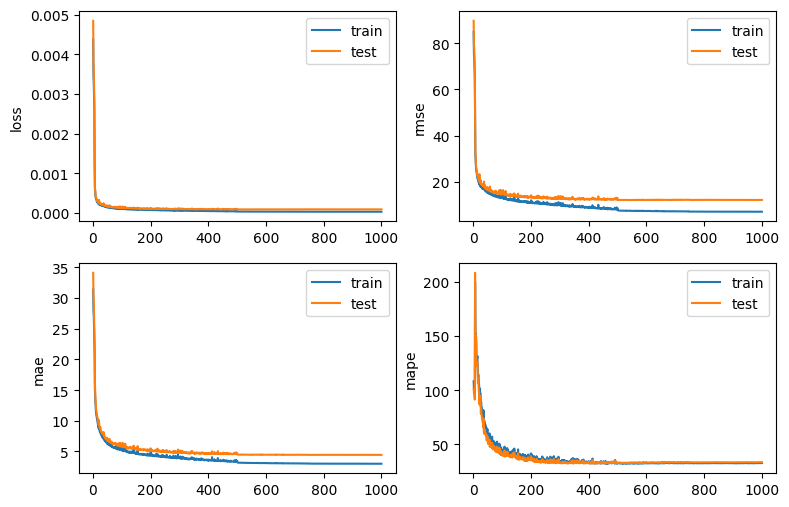

In [26]:
 # metrics curve
fname = "{}_lr{}_b{}_h{}_d{}_metrics.png".format(model_type,lr,batch_size,hidden_size,drop_prob)
drawPlot(metrics,fname,["loss","rmse","mae","mape"]) 